This Notebook demonstrates the package `structure_factor` on the Ginibre ensemble.

In [6]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import matplotlib as mpl
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

%config InlineBackend.figure_format='retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Working with `PointPattern`

The class `StructureFactor` takes as input an object of type `PointPattern`, i.e., an object containing
* `points` : an $n\times d$ `np.ndarray`containing the coordinates of the point process sample under scrutiny. $n$ is the cardinality of the sample, $d$ the dimension of its points. 
* `window`: an object describing the domain of $\mathbb{R}^d$ where the sample is observed. We implement ball and rectangular windows, see `BallWindow` and `BoxWindow` in the module `spatial_windows`.
* `intensity`: a real number giving the intensity of the underlying (stationary) point process. If not provided, it will be approximated.

To illustrate the package, we provide a few point patterns that can be loaded using helpers in `load_data`. For instance, we use here a sample of $10^4$ points from the Ginibre ensemble (actually an approximate sample, since we used the matrix model of the Ginibre ensemble). We also provide evaluations of the pair correlation function and structure factor of the Ginibre ensemble in the module `utils` of `structure_factor`. 


In [7]:
import numpy as np
from structure_factor.data import load_data
import structure_factor.utils as utils

In [8]:
# import ginibre sample
ginibre_pp = load_data.load_ginibre()

<AxesSubplot:>

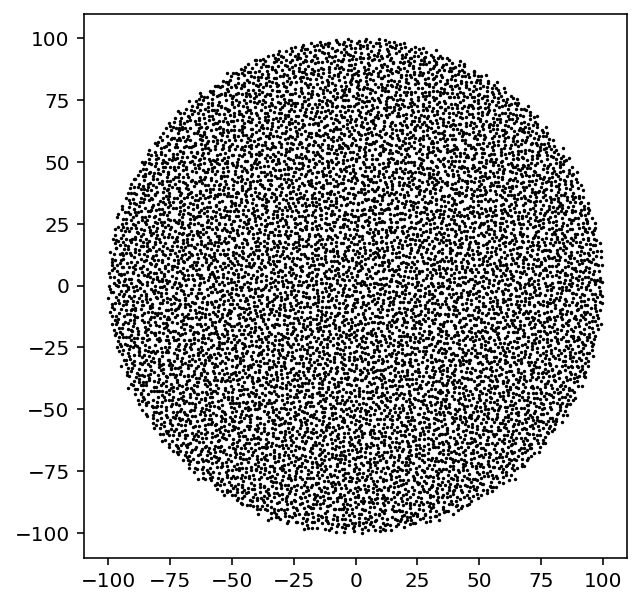

In [9]:
# we provide a method to plot the underlying sample
ginibre_pp.plot() 

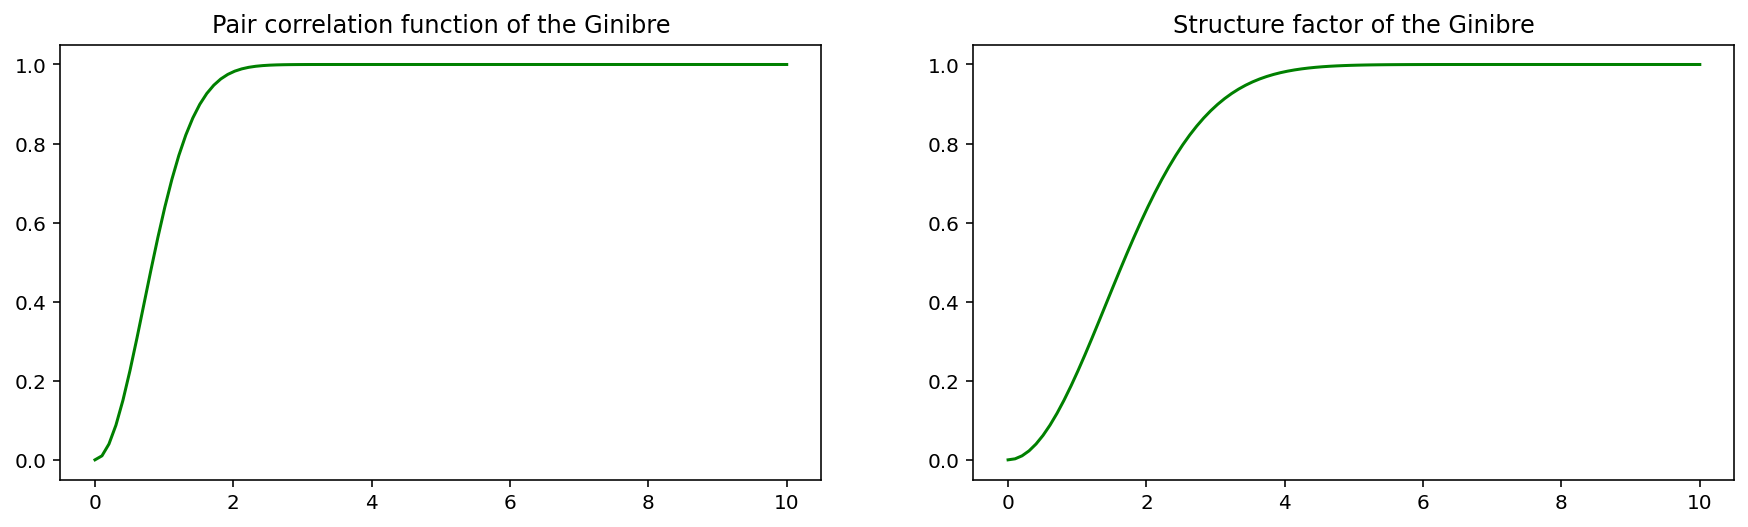

In [10]:
# plot the exact pair correlation function and the structure factor of the Ginibre ensmeble
x = np.linspace(0,10, 100) # radius
pcf_ginibre = utils.pair_correlation_function_ginibre(x) # pcf 
sf_ginibre = utils.structure_factor_ginibre(x) # sf

# plot the pair correlation function and the structure factor of the Ginibre
fig, axis = plt.subplots(1,2, figsize=(15,4))
axis[0].plot(x, pcf_ginibre, 'g')
axis[0].set_title("Pair correlation function of the Ginibre")
axis[1].plot(x, sf_ginibre, 'g')
axis[1].set_title("Structure factor of the Ginibre")
plt.show()

Approximating the structure factor can be done within the `StructureFactor` class, which takes a `PointPattern` as input.

In [11]:
from structure_factor.structure_factor import StructureFactor
sf_ginibre = StructureFactor(ginibre_pp) 

# 2. The scattering intensity estimator $\widehat{S}_{\text{SI}}$
The scattering intensity requires a **cubic window** and should be evaluated on allowed wavevectors, a.k.a. dual lattice points. We start by using the method `restrict_to_window` to restrict our Ginibre sample to a cubic window.

Restricting the window to a cube of length 70.71067811865474


<AxesSubplot:>

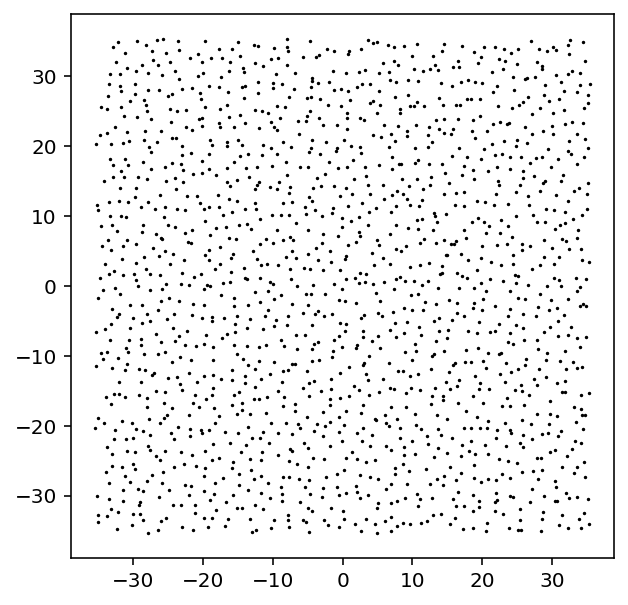

In [12]:
# Restrict the Ginibre pattern to a cubic window
from structure_factor.spatial_windows import BoxWindow
L = ginibre_pp.window.radius/np.sqrt(2) # sidelength of the cubic window
print("Restricting the window to a cube of length", L)
bounds = [[-L/2, L/2], [-L/2, L/2]] 
window = BoxWindow(bounds) # create a cubic window
ginibre_pp_box = ginibre_pp.restrict_to_window(window) # create a Ginibre point pattern with box window
ginibre_pp_box.plot()

In [13]:
from structure_factor.spatial_windows import BoxWindow
bounds = np.array([[-2, 2], [-2, 2], [-2,2]])
window = BoxWindow(bounds)
print("The volume of the window is equal to", window.volume)

The volume of the window is equal to 64


In [14]:
sf_ginibre_box = StructureFactor(ginibre_pp_box) # initialize a new instance of StructureFactor

We now compute the scattering intensity of the point pattern ginibre_pp_box, on an automatically generated mehsgrid of allowed wavevectors; see paper for details. Allowed wavevectors are automatically generated when calling the method `compute_sf_scattering_intensity`.

In [19]:
k, si = sf_ginibre_box.scattering_intensity(
                                    k_max=6, 
                                    meshgrid_shape=(100, 100),
                                    )

The method `plot_scattering_intensity` plots the result of `compute_sf_scattering_intensity`.

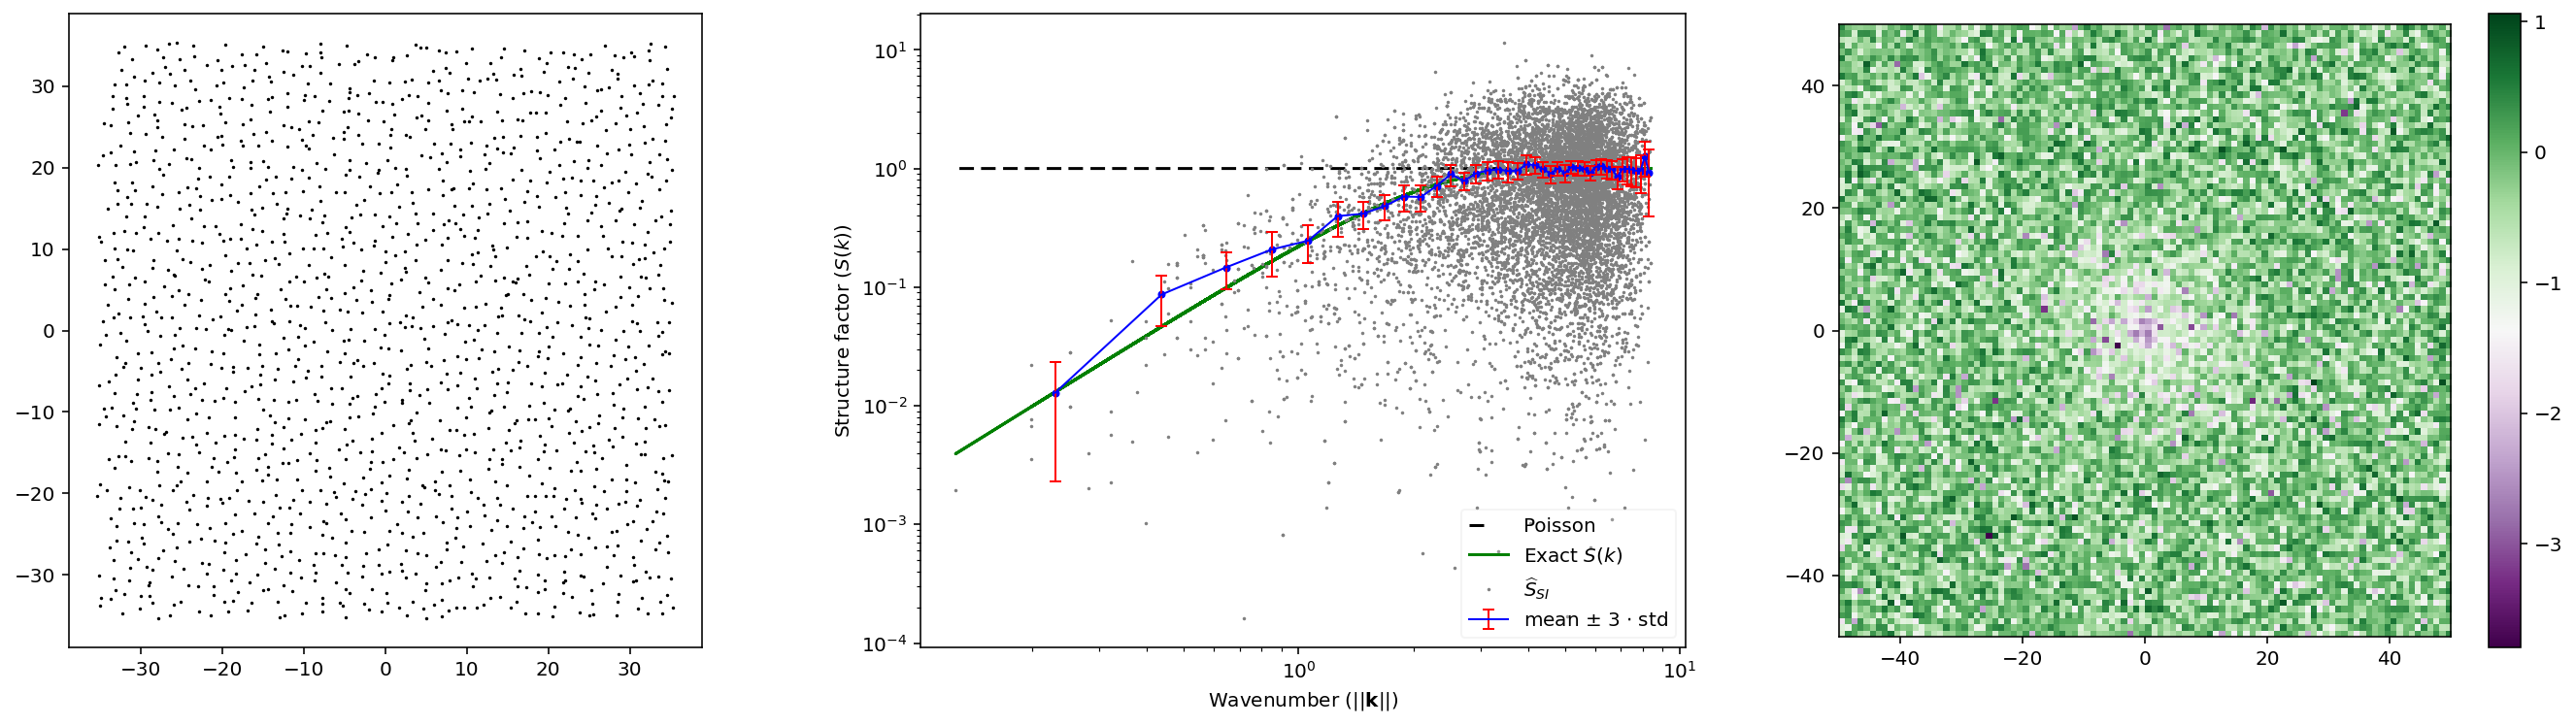

In [21]:
fig = sf_ginibre_box.plot_scattering_intensity(k, si, plot_type="all",
                                            exact_sf=utils.structure_factor_ginibre,
                                            bins=40, error_bar=True,
                                            #file_name="si_ginibre.pdf"
                                              )

By default, the scattering intensity is evaluated at allowed wavevectors (a.k.a. the dual lattice to the observation window). However, we also accomodate evaluations at arbitrary points. Here, we demonstrate this using an arbitrary meshgrid of non-allowed wave vectors. 

In [22]:
x = np.linspace(-4, 4, 100)
x = x[x != 0]
X, Y = np.meshgrid(x, x)
k1 = np.column_stack((X.ravel(), Y.ravel()))
k_norm1, si1 = sf_ginibre_box.scattering_intensity(
                                    k=k1, 
                                    )

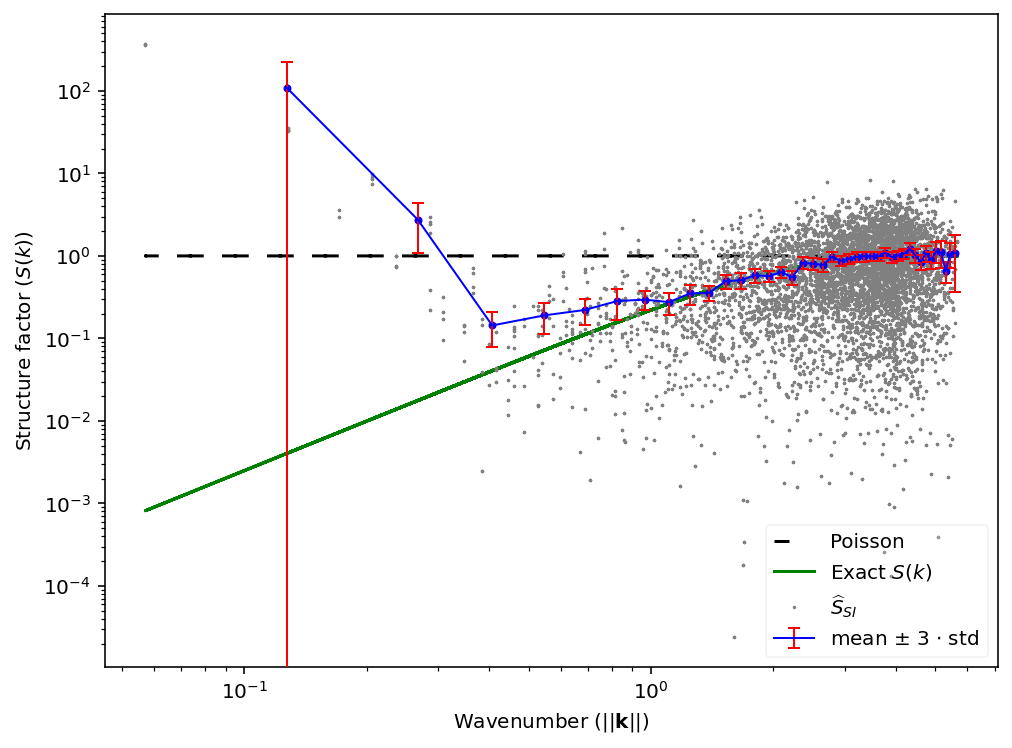

In [23]:
# plot the scattering intensity and compare it to its exact value
fig = sf_ginibre_box.plot_scattering_intensity(k_norm1, si1, plot_type="radial",
                                            exact_sf=utils.structure_factor_ginibre,
                                            bins=40, error_bar=True,
                                            #file_name="si_ginibre.pdf"
                                              )

The bias at small (non-allowed) values of $\Vert k\Vert$ is important. Now, we show how using a non-rectangular window also introduces bias. More precisely, we try and compute the scattering intensity for the Ginibre sample stored in `ginibre_pp`, observed in a ball window.

In [26]:
k2, _ = utils.allowed_wave_vectors(d=2, L=ginibre_pp.window.radius, 
                                   k_max=6, meshgrid_shape=(100,100)) # create allowed values
k_norm2, si2 = sf_ginibre.scattering_intensity(k=k2)

<AxesSubplot:xlabel='Wavenumber ($||\\mathbf{k}||$)', ylabel='Structure factor ($S(k)$)'>

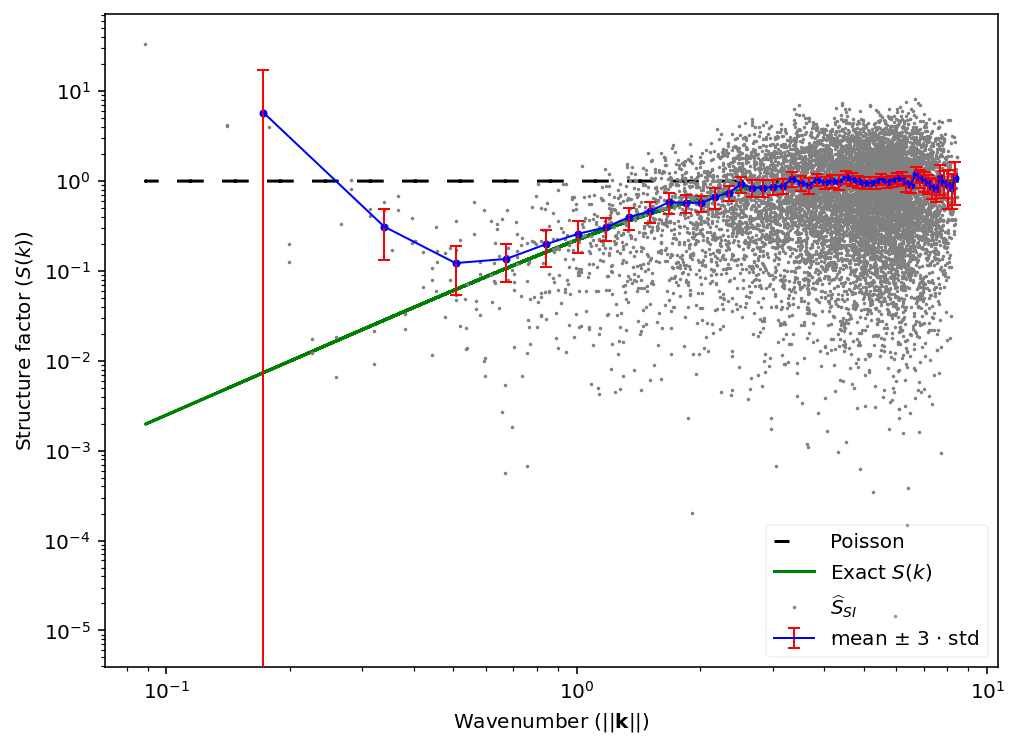

In [27]:
sf_ginibre.plot_scattering_intensity(k_norm2, si2,
                                            exact_sf=utils.structure_factor_ginibre,
                                            bins=50, error_bar=True,
                                            #file_name="si_ginibre.pdf"
                                              )

Again, there is serius overestimation for $\Vert \mathbf k\Vert \leq 1$. 

To conclude, and to insist on the role of *allowed* wavevectors for the scattering intensity at small $\Vert \mathbf k\Vert$, we plot all three estimates on the same figure. 

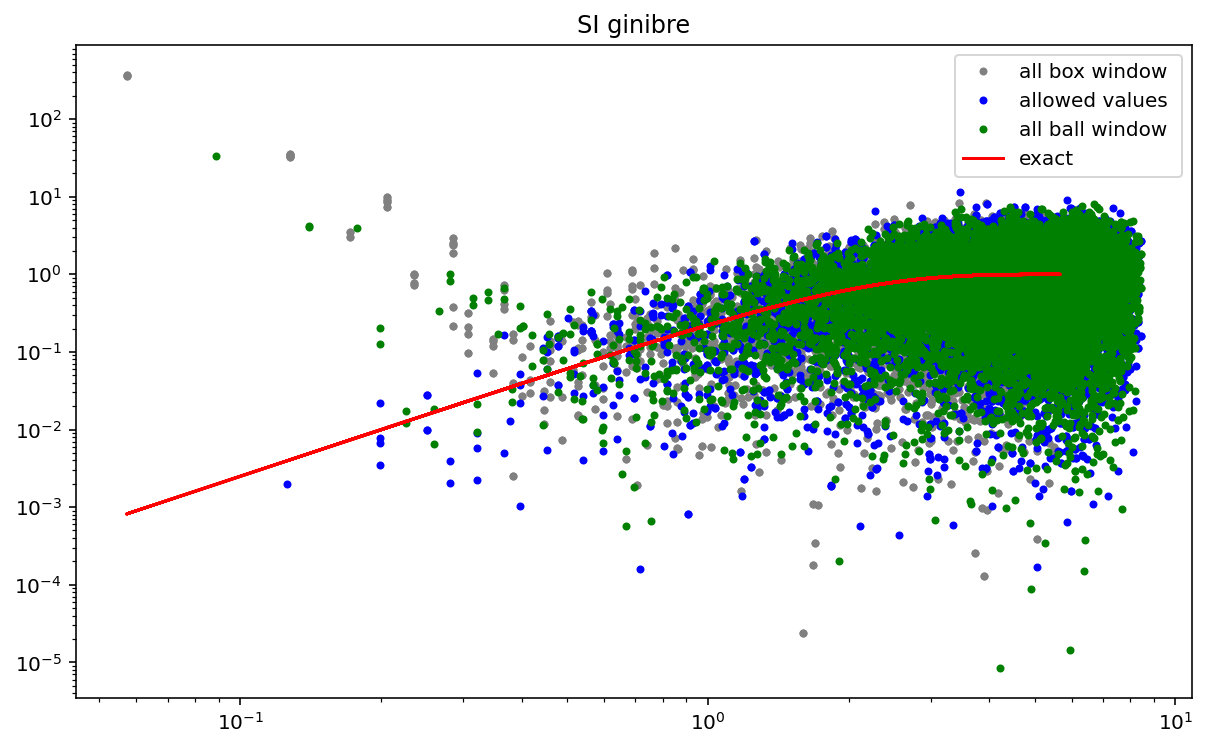

In [28]:
plt.figure(figsize=(10,6))
plt.loglog(k_norm1.ravel(), si1.ravel(), color="grey",linestyle="", marker=".", label="all box window ")
plt.loglog(k.ravel(), si.ravel(), 'b.', label="allowed values")
plt.loglog(k_norm2.ravel(), si2.ravel(), 'g.', label="all ball window ")
plt.loglog(k_norm1.ravel(), utils.structure_factor_ginibre(k_norm1.ravel()), 'r', label="exact")
plt.legend()
plt.title("SI ginibre")
plt.show()

# 3. Estimators relying on the Hankel transform

**Warning:** This section relies on an interface between Python and R. Make sure that the R Programming language is available on your machine. For installation, see https://www.r-project.org/ 

For stationary and isotropic point processes, the structure factor can be expressed as a Hankel transform. As we mentioned another two estimated could be derived for an isotropic point process using the Hankel transform.
- $\widehat{S}_{HO}$: derived by estimating the Hankel transform using Ogata quadrature.
- $\widehat{S}_{HBC}$: derived by estimating the Hankel transform by the Discrete Hankel transform defined by Baddour and Chouinard.

A prior step before estimating the Symmetric Fourier transform is to estimate the pair correlation function. For that we use the two method `pcf.ppp` and `pcf.fv` of the `spatstat` package from R.
- `pcf.ppp` use an estimator of the pair correlation function with the Epanechnikov kernel, and a bandwidth selected by Stoyan’s rule of thumb; this estimator failed at small distances $r$, and its variance becomes infinite for many point processes.
- `pcf.fv`is particularly useful in large datasets, where direct estimation of $g(r)$ can be time-consuming. Thus an estimator $\widehat{g}$ is derived by estimating the derivative of the Ripley's function $K'$.
- After estimating a discrete sample from the pair correlation function we inetrpolate the result to get a function.

## Estimating the pair correlation function

- To use the methods of `spatstat`, a hidden interface will be automatically built between `structure_factor` in Python and `spatstat` in R.
- This doesn't require any knowledge of  R.

In [ ]:
# estimate the pair correlation function using pcf.ppp
r= np.linspace(0, 30, 500)
pcf_ppp = sf_ginibre.compute_pcf(method="ppp", r=r,
                                        correction="all")
pcf_ppp

In [ ]:
fig = sf_ginibre.plot_pcf(pcf_ppp, exact_pcf=utils.pair_correlation_function_ginibre,
                    figsize=(10,6),
                    color=['b', 'grey', 'darkcyan'],
                    style=[".", "o", "^"])

In [ ]:
#pcf_fv = sf_ginibre.compute_pcf(method="fv")
#pcf_fv

In [ ]:
# estimate the pair correlation function using pcf.fv
pcf_fv = sf_ginibre.compute_pcf(method="fv", Kest=dict(rmax=45),
                                        fv=dict(method="b", spar=0.1))
pcf_fv

In [ ]:
fig = sf_ginibre.plot_pcf(pcf_fv, exact_pcf=utils.pair_correlation_function_ginibre,
                    figsize=(10,6),
                    color=[ 'grey','b', 'darkcyan'],
                    style=[".", "o", "^"])

## Interpolating the estimated sample of the pair correlation function

The interpolation can be done using `interpolate_pcf` which automatically clean the possible nan and inf in the data by setting the parameter `clean=True`.

In [ ]:
# interpolation of the approximated pair correlation function
domain, pcf_fv_func = sf_ginibre.interpolate_pcf(
        r=pcf_fv["r"], pcf_r=pcf_fv["pcf"], 
        clean=True # removing nan and inf 
)

## Estimator using Ogata Hankel transform $\widehat{S}_{HO}$

We also estimate a minimal wavenumber bound depending on the maximal radius of the estimations of the pair correlation function.

In [ ]:
r_max = domain["r_max"] # upper bound of the raduis on which the pcf has been approximated
k_norm3 = np.linspace(1.5, 10, 1000) # vector of wave length
k_norm3, sf_Ogata = sf_ginibre.hankel_quadrature(pcf_fv_func,
                                                 method="Ogata",
                                                 k_norm=k_norm3, 
                                                 step_size=0.1,
                                                 nb_points=1000,
                                                 r_max=r_max
                                                )
k_norm_min = sf_ginibre.k_norm_min
print("The minimal wavenumber estimated bound is", k_norm_min)

In [ ]:
fig = sf_ginibre.plot_sf_hankel_quadrature(k_norm3, sf_Ogata, error_bar=True,
                             k_norm_min=k_norm_min, bins=40,
                             exact_sf=utils.structure_factor_ginibre,
                             label="$\widehat{S}_{HO}(k)$",
                             #file_name="sf_ginibre_Ogata.pdf"
                                          )

To test the effect of the estimation of the pair correlation function on the estimator $\widehat{S}_{HO}$, we take the same sample of the pair correlation function from the **exact** pair correlation function, and we re-estimate $\widehat{S}_{HO}$.

In [ ]:
k_norm3 = np.linspace(0.5,10, 1000)
r = pcf_fv["r"]

domain, pcf_func = sf_ginibre.interpolate_pcf(r=r, pcf_r=utils.pair_correlation_function_ginibre(r), clean=True) #interpolation
k_norm3, sf_Ogata = sf_ginibre.hankel_quadrature(pcf_func, k_norm=k_norm3,
                                                step_size=0.01,
                                                nb_points=1000) 

fig = sf_ginibre.plot_sf_hankel_quadrature(k_norm3, sf_Ogata, exact_sf=utils.structure_factor_ginibre)


As predicted the regularite of the estimator $\widehat{S}_{HO}$ is strongly dependent on the regularity of the estimated pair correlation sample.

## Estimator using Baddour and Chouinard Hankel transform $\widehat{S}_{HBC}$

In [ ]:
rmax = domain["rmax"]
k_norm4 = np.linspace(0.3,30, 2000)
k_norm4, sf_BadChou = sf_ginibre.hankel_quadrature(pcf_fv_func, method ="BaddourChouinard",
                                                            k_norm=k_norm4, rmax=rmax, nb_points=1000)

In [ ]:
fig = sf_ginibre.plot_sf_hankel_quadrature(k_norm4, sf_BadChou, exact_sf=utils.structure_factor_ginibre, 
                                           label="$S_{HBC}(k)$", error_bar=True, bins=100)

To test the effect of the estimation of the pair correlation function on the estimator $\widehat{S}_{HBC}$, we take the same sample of the pair correlation function from the **exact** pair correlation function, and we re-estimate $\widehat{S}_{BC}$.

In [ ]:
# Method of Baddour and Chouinard
k_norm4, sf_BaddChou = sf_ginibre.hankel_quadrature(pcf_func, method="BaddourChouinard",rmax=rmax, nb_points=800) 

fig = sf_ginibre.plot_sf_hankel_quadrature(k_norm4, sf_BaddChou, exact_sf=utils.structure_factor_ginibre)

As predicted the regularity of the estimator $\widehat{S}_{HBC}$ is strongly dependent on the regularity of the estimated pair correlation sample.

# Section 4

# Testing the hyperuniformity

We provide two tests of hyperuniformity:
- Test of effective hyperunifromity using the H index 
- Test of the power decay of the structure factor to predict the class of hyperuniofrmity

## Test of effective Hyperuniformity 

In [ ]:
from structure_factor.hyperuniformity import Hyperuniformity
hyperuniformity_test = Hyperuniformity(k, si)
hyperuniformity_test.bin_data(bins=60)


In [ ]:
H_ginibre, std = hyperuniformity_test.effective_hyperuniformity(k_norm_stop=1)
print("H_ginibre=", H_ginibre)

As $H <10^{-3}$ so the test success to predict the hyperuniformity of the Ginibre ensemble.

The bellow plot show the fitted regression line used to find the H index 

In [ ]:
import matplotlib.pyplot as plt
mean_k_norm = hyperuniformity_test.k_norm
mean_sf = hyperuniformity_test.sf
fitted_sf_line = hyperuniformity_test.fitted_line # fitted ligne to sf
index_peak = hyperuniformity_test.i_first_peak # index of first peak of sf
x = np.linspace(0, 5, 300)
y = np.linspace(0,15, 500)
fig=plt.figure(figsize=(10,6))
plt.plot(mean_k_norm, mean_sf, 'b.', label="approx_sf")
plt.plot(mean_k_norm, mean_sf, 'b', label="approx_sf")
plt.plot(x, fitted_sf_line(x), 'r--', label= "fitted line")
plt.plot(y, utils.structure_factor_ginibre(y), 'g', label="exact sf")
plt.plot(mean_k_norm[index_peak], mean_sf[index_peak], 'k*', label="first peak")
plt.legend()
plt.xlabel('wavelength ($||\mathbf{k}||$)')
plt.ylabel('Structure factor ($\mathsf{S}(\mathbf{k})$)')
plt.show()
#fig.savefig("fitted_si_ginibre.pdf", bbox_inches="tight")

## Test the power decay of the structure factor

In [ ]:
hyperuniformity_test = Hyperuniformity(k, si)
hyperuniformity_test.bin_data(bins=90)
sf_power_decay, c = hyperuniformity_test.hyperuniformity_class(k_norm_stop=1)
print("The estimated power of the decay to zero of the approximated structure factor is:", sf_power_decay)

As we know the power decay associated with the Ginibre ensemble is equal to 2, and the estimated value is  around 1.9.
Thus `structure_factor` gave a good prediction of this power decay.

In [ ]:
import matplotlib.pyplot as plt
mean_k_norm = hyperuniformity_test.k_norm
mean_sf = hyperuniformity_test.sf
fitted_poly = hyperuniformity_test.fitted_poly
x = np.linspace(0, 2, 300)
y = np.linspace(0,9, 500)
fig=plt.figure(figsize=(10,6))
plt.plot(mean_k_norm, mean_sf, 'b.', label="approx_sf")
plt.plot(mean_k_norm, mean_sf, 'b', label="approx_sf")
plt.plot(y, utils.structure_factor_ginibre(y), 'g', label="exact sf")
plt.plot(x, fitted_poly(x), 'r--', label= "fitted line")
plt.legend()
plt.xlabel('wavelength ($||\mathbf{k}||$)')
plt.ylabel('Structure factor ($\mathsf{S}(\mathbf{k})$)')
plt.show()
#fig.savefig("fitted_si_ginibre.pdf", bbox_inches="tight")